In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x )
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('paper',font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

from time import time
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import math
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
df=pd.read_csv("AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month          144 non-null object
#Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [13]:
df['Date']= pd.to_datetime(df['Month'])
df.head()

,Month,#Passengers,Date
0,1949-01-01,112,1949-01-01
1,1949-02-01,118,1949-02-01
2,1949-03-01,132,1949-03-01
3,1949-04-01,129,1949-04-01
4,1949-05-01,121,1949-05-01


In [18]:
df['Day']=df['Date'].apply(lambda x: x.day)
df['Month']=df['Date'].apply(lambda x: x.month)
df['Quarter']=df['Date'].apply(lambda x: x.quarter)
df['Year']=df['Date'].apply(lambda x: x.year)

In [17]:
df['Weekday']=df.apply(lambda x: x['Date'].weekday(),axis=1)
df['Weekday']=(df['Weekday']<5).astype(int)
df.sort_values('Date',inplace=True,ascending=True)
df= df.reset_index(drop=True)
df.head()

,Month,#Passengers,Date,Day,Quarter,Year,Weekday
0,1,112,1949-01-01,1,1,1949,0
1,2,118,1949-02-01,1,1,1949,1
2,3,132,1949-03-01,1,1,1949,1
3,4,129,1949-04-01,1,2,1949,1
4,5,121,1949-05-01,1,2,1949,0


In [19]:
stats,p = stats.normaltest(df['#Passengers'])
alpha=0.01
print("##############################################")
print("Hypotheses : ")
print("         H0: Data is a Gaussian Distribution")
print("         Ha: Data isn't a Gaussian")
if p > alpha:
    print("Fail to reject H0")
else:
    print("Reject H0")
print("##############################################")

##############################################
Hypotheses : 
         H0: Data is a Gaussian Distribution
         Ha: Data isn't a Gaussian
Fail to reject H0
##############################################


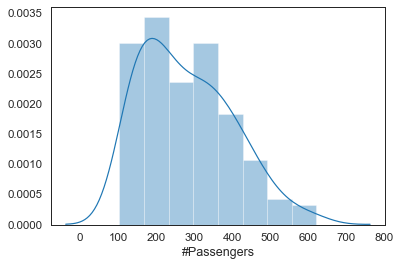

In [22]:
#From the plot below it is evident that the data follows almost Gaussian Distribution
sns.distplot(df['#Passengers'])

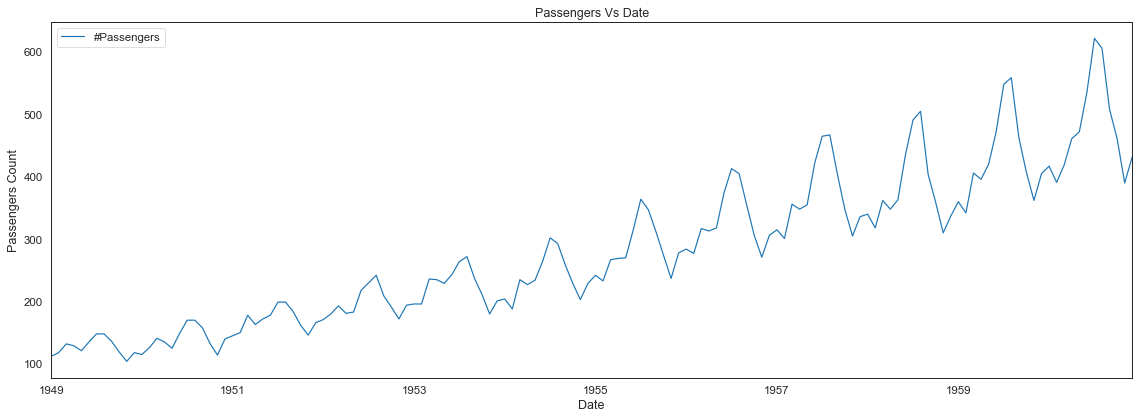

In [39]:
df.plot(x='Date',y='#Passengers',figsize=(16,6))
plt.ylabel("Passengers Count")
plt.title("Passengers Vs Date")
plt.tight_layout()
plt.show()

#There is an upward trend and seasonality in our dataset

In [40]:
len(df)

144

In [42]:
def test_stattionarity(series):
    rolmean= series.rolling(window=12).mean()
    rolstd=series.rolling(window=12).std()
    
    plt.figure(figsize=(16,6))
    plt.plot(series, label='Original Data')
    plt.plot(rolmean, label='Rolling mean')
    plt.plot(rolstd, label='Rolling Standard Deviation')
    plt.tight_layout()
    plt.show()
    
    print("Adfuller Test: ")
    dftest = adfuller(series,autolag='AIC')
    dfout = pd.Series(dftest[0:4],index=['Test Statistic', 'p-value','#Lags','#Observation'])
    for k,v in dftest[4].items():
        dfout["Critical Value %s :"%k]= v
    print(dfout)

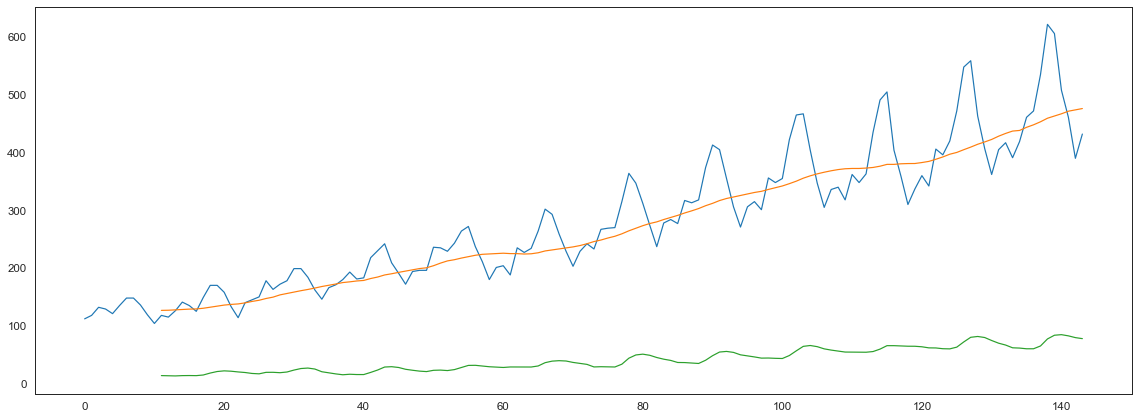

Adfuller Test: 
Test Statistic           0.8154
p-value                  0.9919
#Lags                   13.0000
#Observation           130.0000
Critical Value 1% :     -3.4817
Critical Value 5% :     -2.8840
Critical Value 10% :    -2.5788
dtype: float64


In [43]:
test_stattionarity(df['#Passengers'])

### The above plot shows that the data is not stationary. Let's try to apply LSTM on non-stationary data

In [47]:
dataset = df['#Passengers'].values
dataset = dataset.astype('float32')
dataset = np.reshape(dataset,(-1,1))
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset)*0.80)
test_size =len(dataset) - train_size
train, test = dataset[0:train_size,:],dataset[train_size:len(dataset),:]

In [68]:
def create_dataset(series,lookback=1):
    X,Y=[],[]
    for i in range(len(series)-lookback-1):
        a=series[i:(i+lookback),0]
        X.append(a)
        Y.append(series[[i+lookback],0])
    return np.array(X),np.array(Y)

In [69]:
lookback=1
X_train,Y_train=create_dataset(train,lookback)
X_test,Y_test = create_dataset(test, lookback)

In [70]:
# reshape the input as (samples,time_steps,features)
X_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))
X_train.shape

(113, 1, 1)

In [71]:
X_train.shape

(113, 1, 1)

In [72]:
model = Sequential()
model.add(LSTM(10, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test,Y_test),shuffle=False,verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=5)])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 113 samples, validate on 27 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
113/113 [==============================] - 3s 22ms/sample - loss: 0.0834 - val_loss: 0.3907
Epoch 2/10
113/113 [==============================] - 0s 282us/sample - loss: 0.0831 - val_loss: 0.3775
Epoch 3/10
113/113 [==============================] - 0s 289us/sample - loss: 0.0783 - val_loss: 0.3645
Epoch 4/10
113/113 [==============================] - 0s 420us/sample - loss: 0.0733 - val_loss: 0.3517
Epoch 5/10
113/113 [==============================] - 0s 339us/sample - loss: 0.0687 - val_loss: 0.3393
Epoch 6/10
113/113 [==============================] - 0s 296us/sample - loss: 0.0662 - val_loss: 0.3272
Epoch 7/10
113/113 [==============================] - 0s 255us/sample - loss: 0.0634 - val_loss: 0.3155
Epoch 8/10
113/1

In [73]:
train_predict= model.predict(X_train)
test_predict = model.predict(X_test)
print(Y_train.shape)
print(train_predict.shape)
print(Y_test.shape)
print(test_predict.shape)

(113, 1)
(113, 1)
(27, 1)
(27, 1)


In [77]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform(Y_train)
Y_test = scaler.inverse_transform(Y_test)

In [79]:
print("Train Mean Absolute Error: ",mean_absolute_error(Y_train,train_predict))
print("Train Root Mean Square Error : ",np.sqrt(mean_squared_error(Y_train,train_predict)))

print("==================================================")

print("Test Mean Absolute Error: ",mean_absolute_error(Y_test,test_predict))
print("Test Root Mean Square Error : ",np.sqrt(mean_squared_error(Y_test,test_predict)))

Train Mean Absolute Error:  90.105865
Train Root Mean Square Error :  116.56167
Test Mean Absolute Error:  265.08646
Test Root Mean Square Error :  275.40768


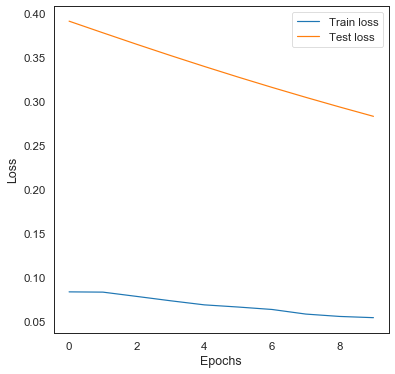

In [82]:
#Plotting loss
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label="Train loss")
plt.plot(history.history['val_loss'],label="Test loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.show()

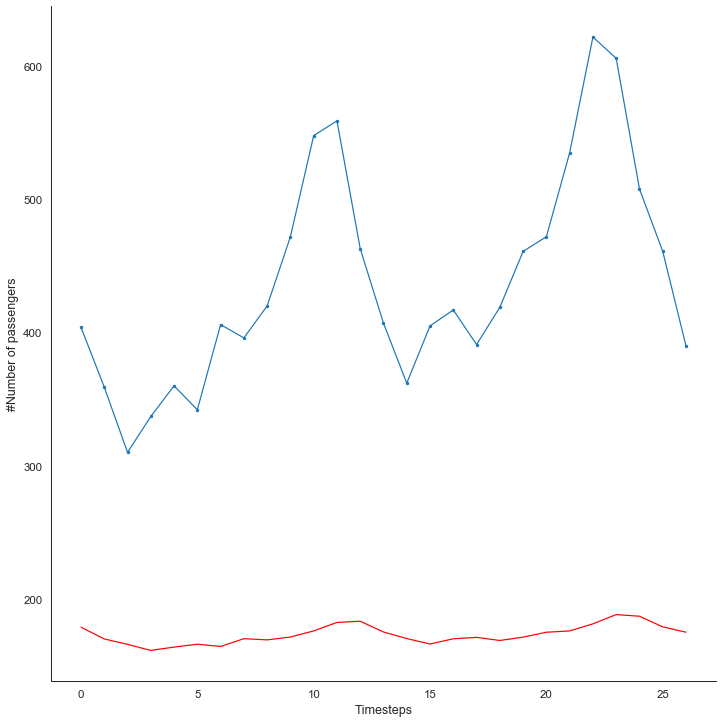

In [93]:
time= [x for x in range(len(Y_test))]
Y_test=Y_test.reshape(-1,1)
plt.figure(figsize=(10,10))
plt.plot(time,Y_test,marker='.',label='Actual')
plt.plot(time,test_predict,'r',label='Predicted')
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('#Number of passengers')
plt.xlabel('Timesteps')
plt.show()

### It has a lot of errors. Let's try after removing the trend and seasonality component in the series

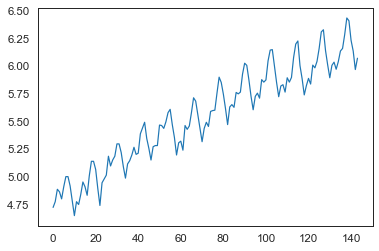

In [94]:
# First : applying log to our value to remove time dependency

df_log=np.log(df['#Passengers'])
plt.plot(df_log)

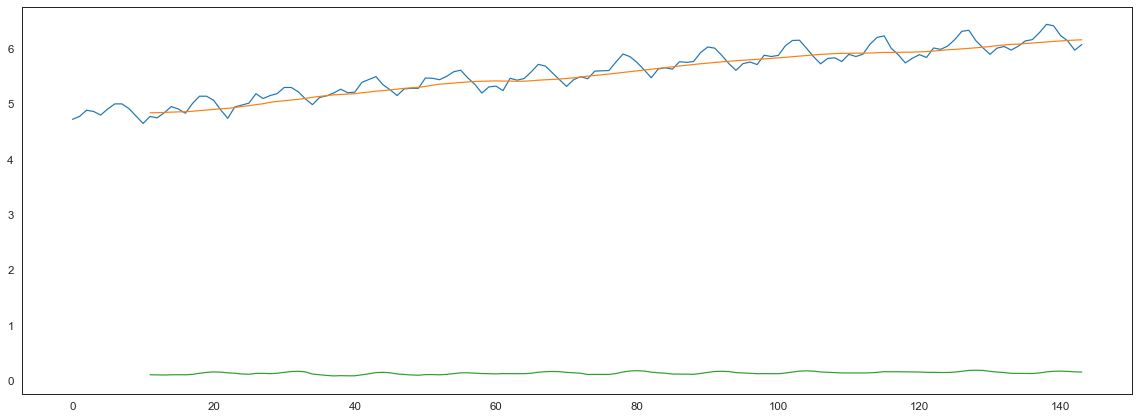

Adfuller Test: 
Test Statistic          -1.7170
p-value                  0.4224
#Lags                   13.0000
#Observation           130.0000
Critical Value 1% :     -3.4817
Critical Value 5% :     -2.8840
Critical Value 10% :    -2.5788
dtype: float64


In [95]:
test_stattionarity(df_log)

In [103]:
## The above plot shows some trend, let's subtract moving average from the series
moving_average=df_log.rolling(window=3).mean()
ma_diff= df_log - moving_average

pandas.core.series.Series

In [105]:
#ma_diff= ma_diff.dropna(inplace=True)
ma_diff.dropna(inplace=True)

2      0.0921
3      0.0220
4     -0.0503
5      0.0516
6      0.0978
        ...  
139    0.0329
140   -0.1263
141   -0.1235
142   -0.1439
143    0.0124
Name: #Passengers, Length: 142, dtype: float64

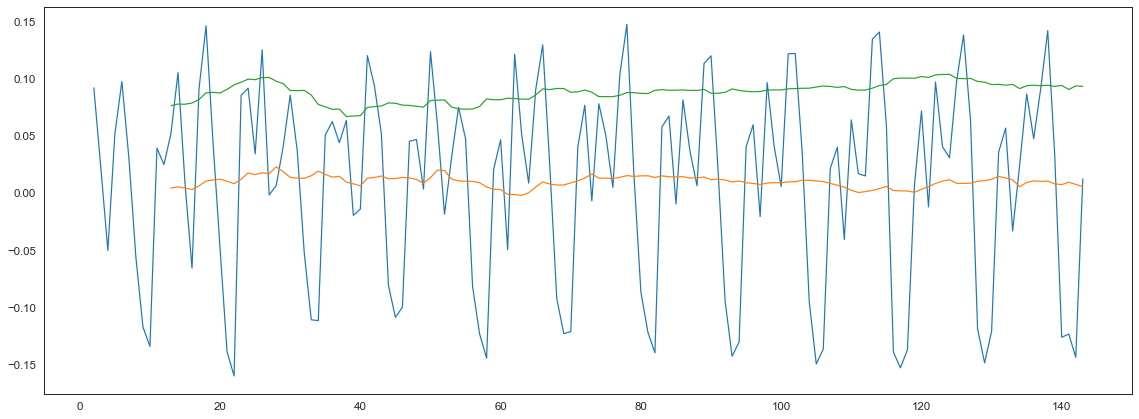

Adfuller Test: 
Test Statistic          -3.0400
p-value                  0.0313
#Lags                   11.0000
#Observation           130.0000
Critical Value 1% :     -3.4817
Critical Value 5% :     -2.8840
Critical Value 10% :    -2.5788
dtype: float64


In [106]:
test_stattionarity(ma_diff)

### It is non-stationary

In [110]:
dataset1 = ma_diff.values
dataset1 = dataset.astype('float32')
dataset1 = np.reshape(dataset1,(-1,1))
scaler1 = MinMaxScaler(feature_range=(0,1))
dataset1 = scaler.fit_transform(dataset1)
train_size = int(len(dataset1)*0.80)
test_size =len(dataset1) - train_size
train, test = dataset1[0:train_size,:],dataset1[train_size:len(dataset1),:]

In [111]:
def create_dataset(series,lookback=1):
    X,Y=[],[]
    for i in range(len(series)-lookback-1):
        a=series[i:(i+lookback),0]
        X.append(a)
        Y.append(series[[i+lookback],0])
    return np.array(X),np.array(Y)

In [124]:
lookback=1
X_train,Y_train=create_dataset(train,lookback)
X_test,Y_test = create_dataset(test, lookback)

In [125]:
# reshape the input as (samples,time_steps,features)
X_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))
X_train.shape

(113, 1, 1)

In [126]:
model1 = Sequential()
model1.add(LSTM(10, input_shape=(X_train.shape[1],X_train.shape[2])))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')
history = model1.fit(X_train, Y_train, epochs=10, validation_data=(X_test,Y_test),shuffle=False,verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=5)])

Train on 113 samples, validate on 27 samples
Epoch 1/10
113/113 [==============================] - 2s 22ms/sample - loss: 0.1177 - val_loss: 0.5326
Epoch 2/10
113/113 [==============================] - 0s 280us/sample - loss: 0.1117 - val_loss: 0.5181
Epoch 3/10
113/113 [==============================] - 0s 272us/sample - loss: 0.1046 - val_loss: 0.5037
Epoch 4/10
113/113 [==============================] - 0s 272us/sample - loss: 0.1015 - val_loss: 0.4896
Epoch 5/10
113/113 [==============================] - 0s 300us/sample - loss: 0.0983 - val_loss: 0.4758
Epoch 6/10
113/113 [==============================] - 0s 274us/sample - loss: 0.0931 - val_loss: 0.4624
Epoch 7/10
113/113 [==============================] - 0s 287us/sample - loss: 0.0899 - val_loss: 0.4493
Epoch 8/10
113/113 [==============================] - 0s 334us/sample - loss: 0.0844 - val_loss: 0.4365
Epoch 9/10
113/113 [==============================] - 0s 271us/sample - loss: 0.0829 - val_loss: 0.4241
Epoch 10/10
113/113 

In [127]:
train_predict= model.predict(X_train)
test_predict = model.predict(X_test)
print(Y_train.shape)
print(train_predict.shape)
print(Y_test.shape)
print(test_predict.shape)

(113, 1)
(113, 1)
(27, 1)
(27, 1)


In [128]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform(Y_train)
Y_test = scaler.inverse_transform(Y_test)

In [129]:
print("Train Mean Absolute Error: ",mean_absolute_error(Y_train,train_predict))
print("Train Root Mean Square Error : ",np.sqrt(mean_squared_error(Y_train,train_predict)))

print("==================================================")

print("Test Mean Absolute Error: ",mean_absolute_error(Y_test,test_predict))
print("Test Root Mean Square Error : ",np.sqrt(mean_squared_error(Y_test,test_predict)))

Train Mean Absolute Error:  0.17394954
Train Root Mean Square Error :  0.22502252
Test Mean Absolute Error:  0.5117499
Test Root Mean Square Error :  0.5316751
